# EDA of Magnetospheric Multiscale (MMS) magnetic field time series

In [12]:
import numpy as np
import pandas as pd
import cdflib
import math as m
import seaborn as sns
from scipy import signal
from matplotlib import pyplot as plt
from statsmodels.graphics import tsaplots
from data_import_funcs import read_cdfs, date_1d_dict, read_asc_ts, extract_components
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [3]:
cdf_file = cdflib.CDF("data/mms/mms1_fgm_brst_l2_20171226061243_v5.117.3.cdf")

In [4]:
print(cdf_file.globalattsget(expand = False))

{'Project': 'STP>Solar-Terrestrial Physics', 'Source_name': 'MMS1>MMS Satellite Number 1', 'Discipline': 'Space Physics>Magnetospheric Science', 'Data_type': 'brst_l2', 'Descriptor': 'FGM>Flux Gate Magnetometer', 'File_naming_convention': 'source_descriptor_datatype_yyyyMMddHHmmss', 'Data_version': '5.117.3', 'PI_name': 'J. Burch, C. Russell, W. Magnus', 'PI_affiliation': 'SWRI, UCLA, IWF', 'TEXT': ['The Fluxgate Magnetometers (FGM) on Magnetospheric Multiscale consist of a traditional Analog Fluxgate Magnetometer (AFG), and a Digital Fluxgate magnetometer (DFG). The dual magnetometers are operated as a single instrument providing a single intercalibrated data product. Range changes occur at different times on the two instruments so the gains checked each periapsis can be carried out unambiguously to apoapsis. Cross correlation of calibration parameters can separate causes of the any apparent calibration changes. Use of Electron Drift Instrument (EDI) to determine the field along the r

In [5]:
print(cdf_file.cdf_info()['zVariables']) 

['Epoch', 'mms1_fgm_b_gse_brst_l2', 'mms1_fgm_b_gsm_brst_l2', 'mms1_fgm_b_dmpa_brst_l2', 'mms1_fgm_b_bcs_brst_l2', 'mms1_fgm_flag_brst_l2', 'Epoch_state', 'mms1_fgm_r_gse_brst_l2', 'mms1_fgm_r_gsm_brst_l2', 'label_b_gse', 'label_b_gsm', 'label_b_dmpa', 'label_b_bcs', 'label_r_gse', 'label_r_gsm', 'represent_vec_tot', 'mms1_fgm_hirange_brst_l2', 'mms1_fgm_bdeltahalf_brst_l2', 'mms1_fgm_stemp_brst_l2', 'mms1_fgm_etemp_brst_l2', 'mms1_fgm_mode_brst_l2', 'mms1_fgm_rdeltahalf_brst_l2']


In [6]:
print(cdf_file.varinq('mms1_fgm_b_gse_brst_l2'))
#Note Dim_Sizes:
print("The number of columns for each observation is", format(cdf_file.varinq('mms1_fgm_b_gse_brst_l2')['Dim_Sizes']))

{'Variable': 'mms1_fgm_b_gse_brst_l2', 'Num': 1, 'Var_Type': 'zVariable', 'Data_Type': 21, 'Data_Type_Description': 'CDF_REAL4', 'Num_Elements': 1, 'Num_Dims': 1, 'Dim_Sizes': [4], 'Sparse': 'No_sparse', 'Last_Rec': 19199, 'Rec_Vary': True, 'Dim_Vary': [-1], 'Pad': array([-1.e+30], dtype=float32), 'Compress': 6, 'Block_Factor': 4096}
The number of columns for each observation is [4]


In [7]:
print(cdf_file.varattsget('mms1_fgm_b_gse_brst_l2'))

{'CATDESC': 'Magnetic field vector in Geocentric Solar Ecliptic (GSE) cartesian coordinates plus Btotal (128 S/s)', 'DEPEND_0': 'Epoch', 'DISPLAY_TYPE': 'time_series', 'FIELDNAM': 'Magnetic field vector in GSE plus Btotal (128 S/s)', 'FILLVAL': array([-1.e+31], dtype=float32), 'FORMAT': 'E13.5', 'LABL_PTR_1': 'label_b_gse', 'UNITS': 'nT', 'VALIDMIN': array([-20000., -20000., -20000.,      0.], dtype=float32), 'VALIDMAX': array([20000., 20000., 20000., 20000.], dtype=float32), 'VAR_TYPE': 'data', 'SCALETYP': 'linear', 'COORDINATE_SYSTEM': 'GSE', 'SI_CONVERSION': '1.0e-9>T', 'TENSOR_ORDER': array([1]), 'REPRESENTATION_1': 'represent_vec_tot'}


In [9]:
print(cdf_file.varattsget('Epoch'))

{'CATDESC': 'Interval centered time tag (TBC)', 'FIELDNAM': 'Time since Jan 1, 1958', 'FILLVAL': array([-9223372036854775808], dtype=int64), 'LABLAXIS': 'mms1_fgm_brst_Epoch', 'UNITS': 'ns', 'VALIDMIN': array([315576066184000000], dtype=int64), 'VALIDMAX': array([946728069183000000], dtype=int64), 'VAR_TYPE': 'support_data', 'SCALETYP': 'linear', 'MONOTON': 'INCREASE', 'TIME_BASE': 'J2000', 'TIME_SCALE': 'Terrestrial Time', 'REFERENCE_POSITION': 'Rotating Earth Geoid', 'SI_CONVERSION': '1.0e-9>s', 'DELTA_PLUS_VAR': 'mms1_fgm_bdeltahalf_brst_l2', 'DELTA_MINUS_VAR': 'mms1_fgm_bdeltahalf_brst_l2'}


In [10]:
#Note LABL_PTR_1
print('The labels of the columns for each observation are given by the variable', format(cdf_file.varattsget('mms1_fgm_b_gse_brst_l2')['LABL_PTR_1']))

The labels of the columns for each observation are given by the variable label_b_gse


In [14]:
mms_data = read_cdfs(["data/MMS/mms1_fgm_brst_l2_20171226060043_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226061243_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226061513_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226061743_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226062013_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226062233_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226062503_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226062733_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226063003_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226063233_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226063503_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226063733_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226064003_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226064223_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226064453_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226064723_v5.117.3.cdf",
                      "data/MMS/mms1_fgm_brst_l2_20171226064953_v5.117.3.cdf"], 
                      {'Epoch':(0), 'mms1_fgm_b_dmpa_brst_l2':(0,4), 'label_b_gse':(0,4)})
mms_data

reading file  data/MMS/mms1_fgm_brst_l2_20171226060043_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226061243_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226061513_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226061743_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226062013_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226062233_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226062503_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226062733_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226063003_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226063233_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226063503_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226063733_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226064003_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226064223_v5.117.3.cdf
reading file  data/MMS/mms1_fgm_brst_l2_20171226

{'Epoch': array([5.67540112e+17, 5.67540112e+17, 5.67540112e+17, ...,
        5.67543211e+17, 5.67543212e+17, 5.67543212e+17]),
 'mms1_fgm_b_dmpa_brst_l2': array([[ 10.43951511, -11.82417393,  -9.50539112,  18.41594505],
        [ 10.41535282, -11.78449059,  -9.49645424,  18.37216568],
        [ 10.38011837, -11.76355171,  -9.48513222,  18.33291435],
        ...,
        [  9.35509014, -22.65755653,  -1.87720919,  24.58468056],
        [  9.35465145, -22.67634964,  -1.85930514,  24.60047531],
        [  9.3126049 , -22.67075348,  -1.80534935,  24.57533455]]),
 'label_b_gse': array([['Bx GSE    ', 'By GSE    ', 'Bz GSE    ', 'Bt        '],
        ['Bx GSE    ', 'By GSE    ', 'Bz GSE    ', 'Bt        '],
        ['Bx GSE    ', 'By GSE    ', 'Bz GSE    ', 'Bt        '],
        ['Bx GSE    ', 'By GSE    ', 'Bz GSE    ', 'Bt        '],
        ['Bx GSE    ', 'By GSE    ', 'Bz GSE    ', 'Bt        '],
        ['Bx GSE    ', 'By GSE    ', 'Bz GSE    ', 'Bt        '],
        ['Bx GSE    ', 

                                  Bx GSE     By GSE    Bz GSE         Bt
Time                                                                    
2017-12-26 06:01:52.479483776  10.439515 -11.824174 -9.505391  18.415945
2017-12-26 06:01:52.487296384  10.415353 -11.784491 -9.496454  18.372166
2017-12-26 06:01:52.495108992  10.380118 -11.763552 -9.485132  18.332914
2017-12-26 06:01:52.502921600  10.373418 -11.746753 -9.497122  18.324554
2017-12-26 06:01:52.510734208  10.343276 -11.727102 -9.494350  18.293468


array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>],
      dtype=object)

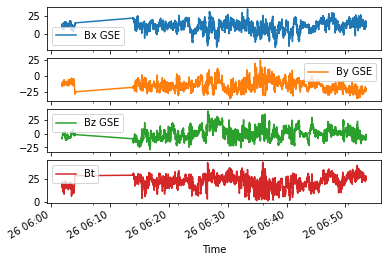

In [19]:
mms_data_final = extract_components(mms_data, 'mms1_fgm_b_dmpa_brst_l2', 'label_b_gse', 'Epoch', 4)
df = pd.DataFrame(mms_data_final)

df['Time'] = pd.to_datetime('2000-01-01 12:00') + pd.to_timedelta(df['Epoch'], unit= 'ns')
df = df.drop(columns = 'Epoch').set_index('Time')

print(df.head())
df.plot(subplots = True)

<AxesSubplot:title={'center':'One minute of magnetic field data from MMS1'}, xlabel='Time', ylabel='nT'>

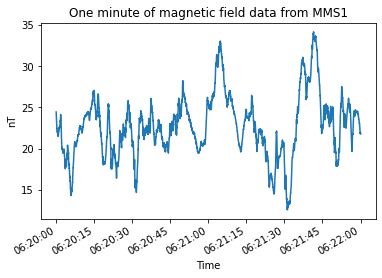

In [20]:
df.Bt['2017-12-26 06:20':'2017-12-26 06:21'].plot(title = "One minute of magnetic field data from MMS1", ylabel = 'nT')

0.18747950983656916
                            Bx GSE     By GSE    Bz GSE         Bt
Time                                                              
2017-12-26 06:01:52.472  10.439515 -11.824174 -9.505391  18.415945
2017-12-26 06:01:52.480  10.415353 -11.784491 -9.496454  18.372166
2017-12-26 06:01:52.488  10.380118 -11.763552 -9.485132  18.332914
2017-12-26 06:01:52.496  10.373418 -11.746753 -9.497122  18.324554
2017-12-26 06:01:52.504  10.343276 -11.727102 -9.494350  18.293468


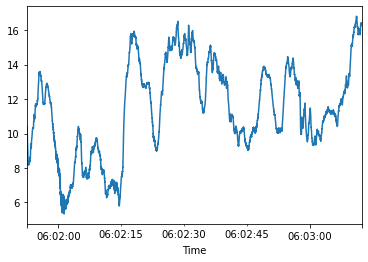

In [23]:
mms_data_final = df.resample('0.008S').mean() #Original frequency is 0.0078S (4dp)
len(mms_data_final)
print(mms_data_final['Bx GSE'].isna().sum()/len(mms_data_final['Bx GSE'])) #No data missing

print(mms_data_final.head())
mms_data_final[:10000]['Bx GSE'].plot()
plt.show()
